In [1]:
# Kala Project 1 Notebook
# Analyzing relationships between cancer rates and death rates AND education and income across all states and counties in the US


In [2]:
# Dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress


In [3]:
# Read the avg-household-size csv data into a DataFrame
df_household_size = pd.read_csv("Resources/avg-household-size.csv")
df_household_size.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             3220 non-null   int64  
 1   statefips         3220 non-null   int64  
 2   countyfips        3220 non-null   int64  
 3   avghouseholdsize  3220 non-null   float64
 4   geography         3220 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 125.9+ KB


In [4]:
# Clean the df, index column is not needed, add new state column for grouping
df_household_size = df_household_size.drop(columns='index')
df_household_size["state"] = df_household_size["geography"].str.split(", ").str.get(1)
df_household_size = df_household_size.set_index('geography')
df_household_size


,statefips,countyfips,avghouseholdsize,state
geography,,,,
"Aleutians East Borough, Alaska",2,13,2.43,Alaska
"Aleutians West Census Area, Alaska",2,16,3.59,Alaska
"Anchorage Municipality, Alaska",2,20,2.77,Alaska
"Bethel Census Area, Alaska",2,50,3.86,Alaska
"Bristol Bay Borough, Alaska",2,60,2.50,Alaska
...,...,...,...,...
"Sweetwater County, Wyoming",56,37,2.64,Wyoming
"Teton County, Wyoming",56,39,2.63,Wyoming
"Uinta County, Wyoming",56,41,2.76,Wyoming


In [5]:
# Read the cancer csv data into a DataFrame
df_cancer = pd.read_csv("Resources/cancer_reg.csv",
    index_col='geography')
df_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3047 entries, Kitsap County, Washington to Geary County, Kansas
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    3047 non-null   int64  
 1   avganncount              3047 non-null   float64
 2   avgdeathsperyear         3047 non-null   int64  
 3   target_deathrate         3047 non-null   float64
 4   incidencerate            3047 non-null   float64
 5   medincome                3047 non-null   int64  
 6   popest2015               3047 non-null   int64  
 7   povertypercent           3047 non-null   float64
 8   studypercap              3047 non-null   float64
 9   binnedinc                3047 non-null   object 
 10  medianage                3047 non-null   float64
 11  medianagemale            3047 non-null   float64
 12  medianagefemale          3047 non-null   float64
 13  percentmarried           3047 non-null   fl

In [6]:
#Drop the index column and display the second df
df_cancer = df_cancer.drop(columns='index')
df_cancer.head(5)

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,...,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
geography,,,,,,,,,,,,,,,,,,,,,
"Kitsap County, Washington",1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
"Kittitas County, Washington",173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
"Klickitat County, Washington",102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
"Lewis County, Washington",427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
"Lincoln County, Washington",57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [7]:
# Merge the 2 dfs into one on index column geography
df_combined = pd.merge(df_household_size, df_cancer, on="geography", how="outer")

# Drop all the rows where avganncount of cancer cases = 1962..., data seems to be incorrect
df_combined = df_combined.loc[df_combined['avganncount'] != 1962.667684]

# Recalculate the death rate and incidence rate as I think the ones in the CSV look incorrect
df_combined['actdeathrate'] = (df_combined['avgdeathsperyear'] * 10000) / df_combined['popest2015']
df_combined['actincidencerate'] = (df_combined['avganncount'] * 10000) / df_combined['popest2015']

In [8]:
# Decided against doing the dropna() because it reduced the number of rows significantly - from 3000+ to 591
#df_combined = df_combined.dropna()
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3014 entries, Aleutians East Borough, Alaska to Weston County, Wyoming
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   statefips                3014 non-null   int64  
 1   countyfips               3014 non-null   int64  
 2   avghouseholdsize         3014 non-null   float64
 3   state                    3014 non-null   object 
 4   avganncount              2841 non-null   float64
 5   avgdeathsperyear         2841 non-null   float64
 6   target_deathrate         2841 non-null   float64
 7   incidencerate            2841 non-null   float64
 8   medincome                2841 non-null   float64
 9   popest2015               2841 non-null   float64
 10  povertypercent           2841 non-null   float64
 11  studypercap              2841 non-null   float64
 12  binnedinc                2841 non-null   object 
 13  medianage                2841 non-nu

In [9]:
df_combined[['popest2015', 'avganncount', 'avgdeathsperyear', 'actincidencerate', 'actdeathrate', 'avghouseholdsize']].corr()

,popest2015,avganncount,avgdeathsperyear,actincidencerate,actdeathrate,avghouseholdsize
popest2015,1.000000,0.981322,0.977250,-0.184675,-0.243105,0.159983
avganncount,0.981322,1.000000,0.996993,-0.137890,-0.214173,0.128817
avgdeathsperyear,0.977250,0.996993,1.000000,-0.134649,-0.199539,0.120801
actincidencerate,-0.184675,-0.137890,-0.134649,1.000000,0.834953,-0.613402
actdeathrate,-0.243105,-0.214173,-0.199539,0.834953,1.000000,-0.556124
avghouseholdsize,0.159983,0.128817,0.120801,-0.613402,-0.556124,1.000000


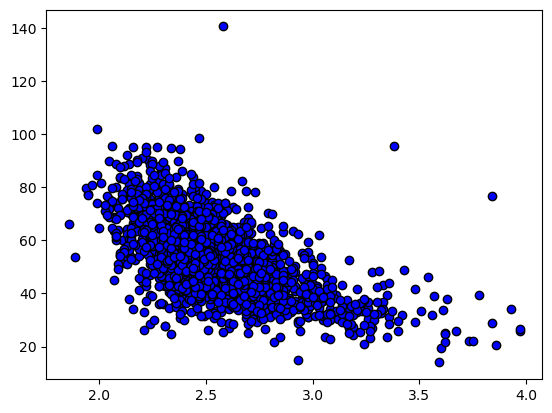

In [10]:
plt.scatter(df_combined['avghouseholdsize'], df_combined['actincidencerate'], marker="o", facecolors="blue", edgecolors="black")
plt.show()

In [11]:
my_educ_cols = ['pcths18_24', 'pctnohs18_24', 'pctsomecol18_24', 'pctbachdeg18_24', 'pcths25_over', 'pctbachdeg25_over']
my_income_cols = ['medincome', 'povertypercent']
my_empl_cols = ['pctemployed16_over', 'pctunemployed16_over']
my_master_cols = ['popest2015', 'avganncount', 'avgdeathsperyear', 'actincidencerate', 'actdeathrate']
df_combined[my_master_cols + my_income_cols].corr()

,popest2015,avganncount,avgdeathsperyear,actincidencerate,actdeathrate,medincome,povertypercent
popest2015,1.000000,0.981322,0.977250,-0.184675,-0.243105,0.242759,-0.076325
avganncount,0.981322,1.000000,0.996993,-0.137890,-0.214173,0.256421,-0.093293
avgdeathsperyear,0.977250,0.996993,1.000000,-0.134649,-0.199539,0.232073,-0.080440
actincidencerate,-0.184675,-0.137890,-0.134649,1.000000,0.834953,-0.278655,-0.003797
actdeathrate,-0.243105,-0.214173,-0.199539,0.834953,1.000000,-0.484419,0.196673
medincome,0.242759,0.256421,0.232073,-0.278655,-0.484419,1.000000,-0.791514
povertypercent,-0.076325,-0.093293,-0.080440,-0.003797,0.196673,-0.791514,1.000000


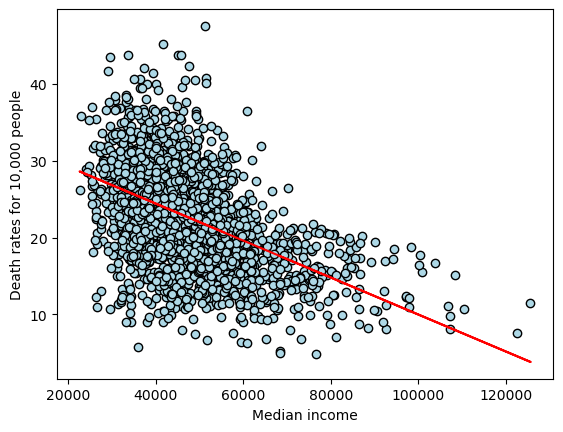

In [12]:
# Plot the linear regression between median income and the death rate
x_values = df_combined['medincome'].dropna()
y_values = df_combined['actdeathrate'].dropna()
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values, y_values, marker="o", facecolors="lightblue", edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('Median income')
plt.ylabel('Death rates for 10,000 people')
plt.show()

## Q1: Is there a relationship between cancer incidence and death rates AND income or poverty level?
1. There is moderate negative correlation between death rate and median income (-0.484419).
1. There is small positive correlation between poverty percent and death rate (0.196673).
### Conclusions:
* Populations that have higher median income will see fewer deaths due to cancer.

In [13]:
df_combined[my_master_cols + my_empl_cols].corr()

,popest2015,avganncount,avgdeathsperyear,actincidencerate,actdeathrate,pctemployed16_over,pctunemployed16_over
popest2015,1.000000,0.981322,0.977250,-0.184675,-0.243105,0.155825,0.039190
avganncount,0.981322,1.000000,0.996993,-0.137890,-0.214173,0.155406,0.046590
avgdeathsperyear,0.977250,0.996993,1.000000,-0.134649,-0.199539,0.143695,0.056539
actincidencerate,-0.184675,-0.137890,-0.134649,1.000000,0.834953,-0.256233,-0.008978
actdeathrate,-0.243105,-0.214173,-0.199539,0.834953,1.000000,-0.422682,0.095523
pctemployed16_over,0.155825,0.155406,0.143695,-0.256233,-0.422682,1.000000,-0.633817
pctunemployed16_over,0.039190,0.046590,0.056539,-0.008978,0.095523,-0.633817,1.000000


In [14]:
# Is there a relationship between cancer incidence and death rates
# and educational level?
df_combined[my_master_cols + my_educ_cols].corr()

,popest2015,avganncount,avgdeathsperyear,actincidencerate,actdeathrate,pcths18_24,pctnohs18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over
popest2015,1.000000,0.981322,0.977250,-0.184675,-0.243105,-0.161725,-0.131032,0.097481,0.259734,-0.314834,0.302023
avganncount,0.981322,1.000000,0.996993,-0.137890,-0.214173,-0.168164,-0.146029,0.105684,0.286953,-0.312100,0.316434
avgdeathsperyear,0.977250,0.996993,1.000000,-0.134649,-0.199539,-0.162539,-0.142050,0.102656,0.273131,-0.299660,0.299379
actincidencerate,-0.184675,-0.137890,-0.134649,1.000000,0.834953,0.181947,0.041062,-0.199665,-0.109741,0.411934,-0.273128
actdeathrate,-0.243105,-0.214173,-0.199539,0.834953,1.000000,0.263231,0.157252,-0.300620,-0.259147,0.531208,-0.473654
pcths18_24,-0.161725,-0.168164,-0.162539,0.181947,0.263231,1.000000,0.087885,-0.771819,-0.380368,0.441129,-0.403451
pctnohs18_24,-0.131032,-0.146029,-0.142050,0.041062,0.157252,0.087885,1.000000,-0.657795,-0.392709,0.225025,-0.398754
pctsomecol18_24,0.097481,0.105684,0.102656,-0.199665,-0.300620,-0.771819,-0.657795,1.000000,0.255188,-0.380780,0.428996
pctbachdeg18_24,0.259734,0.286953,0.273131,-0.109741,-0.259147,-0.380368,-0.392709,0.255188,1.000000,-0.395473,0.609189
pcths25_over,-0.314834,-0.312100,-0.299660,0.411934,0.531208,0.441129,0.225025,-0.380780,-0.395473,1.000000,-0.743755


## Q2: Is there a relationship between cancer incidence and death rates AND educational level?
1. The average number of cancer cases have an extremely weak negative correlation with higher education.  For example, the 3 columns "Some College 18-24 %", "Bachelor Degree 18-24 %" and "Bachelor Degree 25 and Over %" all show a negative correlation to cancer incidence rate, though they are extremely weak correlations.

1. The average number of deaths has a moderate negative correlation (-0.448336) with "Bachelor Degree 25 and Over %" and a moderate positive correlation (0.487745) with "High School 25 and Over %".
### Conclusions:
* Populations that have a greater percentage of people over 25 with a Bachelor's degree will see lower percentage of cancer deaths.  The reverse is also moderately true. Populations that have a greater percentage of people over 25 with only a high school degree will see higher percentage of cancer deaths.

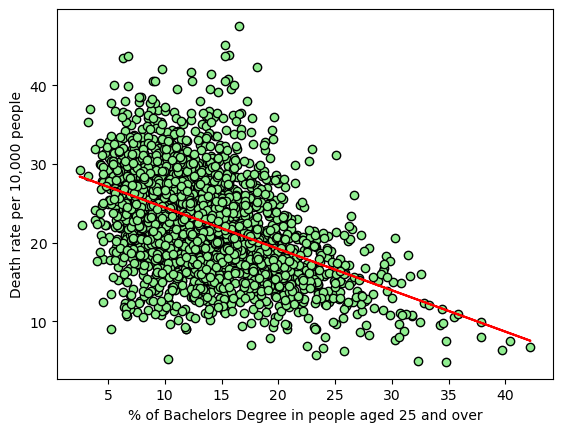

In [15]:
# Check out the linear regression between Bachelor's Degree for ages 25 and over and the death rate
x_values = df_combined['pctbachdeg25_over'].dropna()
y_values = df_combined['actdeathrate'].dropna()
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values, y_values, marker="o", facecolors="lightgreen", edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="blue")
plt.xlabel('% of Bachelors Degree in people aged 25 and over')
plt.ylabel('Death rate per 10,000 people')
plt.show()

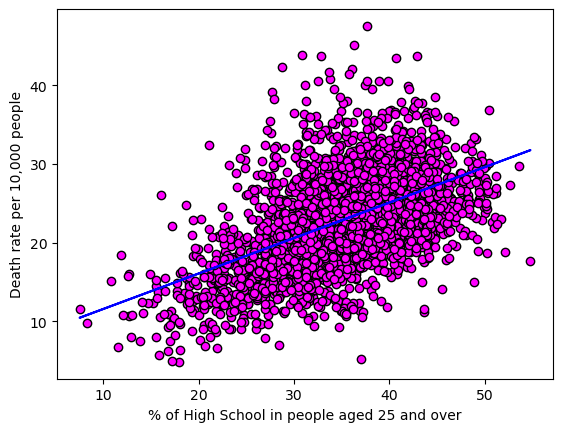

In [18]:
# Check out the linear regression between High School for ages 25 and over and the death rate
x_values = df_combined['pcths25_over'].dropna()
y_values = df_combined['actdeathrate'].dropna()
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values, y_values, marker="o", facecolors="magenta", edgecolors="black")
plt.plot(x_values,regress_values,"b-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15)
plt.xlabel('% of High School in people aged 25 and over')
plt.ylabel('Death rate per 10,000 people')
plt.show()

In [19]:
df_combined.head()

,statefips,countyfips,avghouseholdsize,state,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,...,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate,actdeathrate,actincidencerate
geography,,,,,,,,,,,,,,,,,,,,,
"Aleutians East Borough, Alaska",2,13,2.43,Alaska,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Aleutians West Census Area, Alaska",2,16,3.59,Alaska,8.0,3.0,203.3,201.3,68387.0,5702.0,...,11.2,6.2,31.562280,4.732583,37.156932,5.295567,42.882250,4.391052,5.261312,14.030165
"Anchorage Municipality, Alaska",2,20,2.77,Alaska,1085.0,352.0,167.5,453.3,75200.0,298695.0,...,24.5,12.9,64.944652,5.854427,8.800530,1.747201,48.361303,5.994294,11.784596,36.324679
"Bethel Census Area, Alaska",2,50,3.86,Alaska,37.0,20.0,218.8,338.2,45808.0,17946.0,...,47.3,36.1,12.016202,0.798830,1.175743,0.343159,45.521390,9.156280,11.144545,20.617408
"Bristol Bay Borough, Alaska",2,60,2.50,Alaska,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_groupbystate = df_combined.groupby(['state'])

In [21]:
df_deathrate_bystate = df_groupbystate['actdeathrate'].mean().sort_values(ascending=False)
df_deathrate_bystate

state
West Virginia           26.995672
Arkansas                26.611960
Maine                   25.962321
Kentucky                25.884400
Missouri                25.429451
Michigan                25.155073
Tennessee               25.124169
Illinois                24.743369
Nebraska                24.503467
Iowa                    24.415739
Oklahoma                24.370468
Pennsylvania            24.167337
North Dakota            24.091679
Florida                 23.834462
Alabama                 23.621811
Oregon                  23.565925
Mississippi             23.406259
Wisconsin               23.399671
South Dakota            23.216839
Ohio                    23.139548
Virginia                23.053381
Vermont                 22.834502
Indiana                 22.609445
South Carolina          22.406394
North Carolina          22.375525
Montana                 22.351608
New Hampshire           22.177373
Rhode Island            22.044777
Louisiana               21.787124
New York

In [22]:
df_incidencerate_bystate = df_groupbystate['actincidencerate'].mean().sort_values(ascending=False)
df_incidencerate_bystate

state
Maine                   64.890033
Iowa                    62.996995
Pennsylvania            62.782548
Illinois                62.171509
West Virginia           61.710303
New Hampshire           61.233425
Kentucky                60.795922
Vermont                 60.703831
New York                60.539602
Nebraska                60.114185
Rhode Island            59.962428
Montana                 59.872687
Oregon                  59.336072
North Dakota            58.898059
Michigan                58.384805
Tennessee               57.620694
South Dakota            57.237580
Wisconsin               57.221379
Massachusetts           57.108342
Delaware                57.068865
New Jersey              56.636459
Connecticut             56.552558
North Carolina          56.481294
Arkansas                56.441330
Alabama                 55.983879
Florida                 55.614565
Missouri                55.542639
Ohio                    54.249672
Virginia                54.193930
Washingt

In [23]:
df_population_bystate = df_groupbystate['popest2015'].sum().sort_values(ascending=False)
df_state_ranked = pd.concat([df_population_bystate, df_population_bystate.rank(ascending=False)], axis=1)
df_state_ranked.head(3)

,popest2015,popest2015
state,,
California,39143708.0,1.0
Texas,21316805.0,2.0
Florida,20222673.0,3.0


In [24]:
df_state_ranked = pd.concat([df_state_ranked, df_incidencerate_bystate], axis=1)
df_state_ranked = pd.concat([df_state_ranked, df_incidencerate_bystate.rank(ascending=False)], axis=1)
df_state_ranked.head(3)

,popest2015,popest2015,actincidencerate,actincidencerate
state,,,,
California,39143708.0,1.0,48.435791,40.0
Texas,21316805.0,2.0,47.496124,42.0
Florida,20222673.0,3.0,55.614565,26.0


In [25]:
df_state_ranked = pd.concat([df_state_ranked, df_deathrate_bystate], axis=1)
df_state_ranked = pd.concat([df_state_ranked, df_deathrate_bystate.rank(ascending=False)], axis=1)
df_state_ranked.head(3)

,popest2015,popest2015,actincidencerate,actincidencerate,actdeathrate,actdeathrate
state,,,,,,
California,39143708.0,1.0,48.435791,40.0,18.225865,43.0
Texas,21316805.0,2.0,47.496124,42.0,21.113291,32.0
Florida,20222673.0,3.0,55.614565,26.0,23.834462,14.0


In [26]:
df_state_ranked.columns = ['Population', 'PopulationRank', 'IncidenceRate', 'IncidenceRank', 'DeathRate', 'DeathRank']
df_state_ranked = df_state_ranked.dropna()
df_state_ranked

,Population,PopulationRank,IncidenceRate,IncidenceRank,DeathRate,DeathRank
state,,,,,,
California,39143708.0,1.0,48.435791,40.0,18.225865,43.0
Texas,21316805.0,2.0,47.496124,42.0,21.113291,32.0
Florida,20222673.0,3.0,55.614565,26.0,23.834462,14.0
New York,19795791.0,4.0,60.539602,9.0,21.524134,30.0
Illinois,12859995.0,5.0,62.171509,4.0,24.743369,8.0
Pennsylvania,12802503.0,6.0,62.782548,3.0,24.167337,12.0
Ohio,10361701.0,7.0,54.249672,28.0,23.139548,20.0
Michigan,9922576.0,8.0,58.384805,15.0,25.155073,6.0
North Carolina,9741850.0,9.0,56.481294,23.0,22.375525,25.0


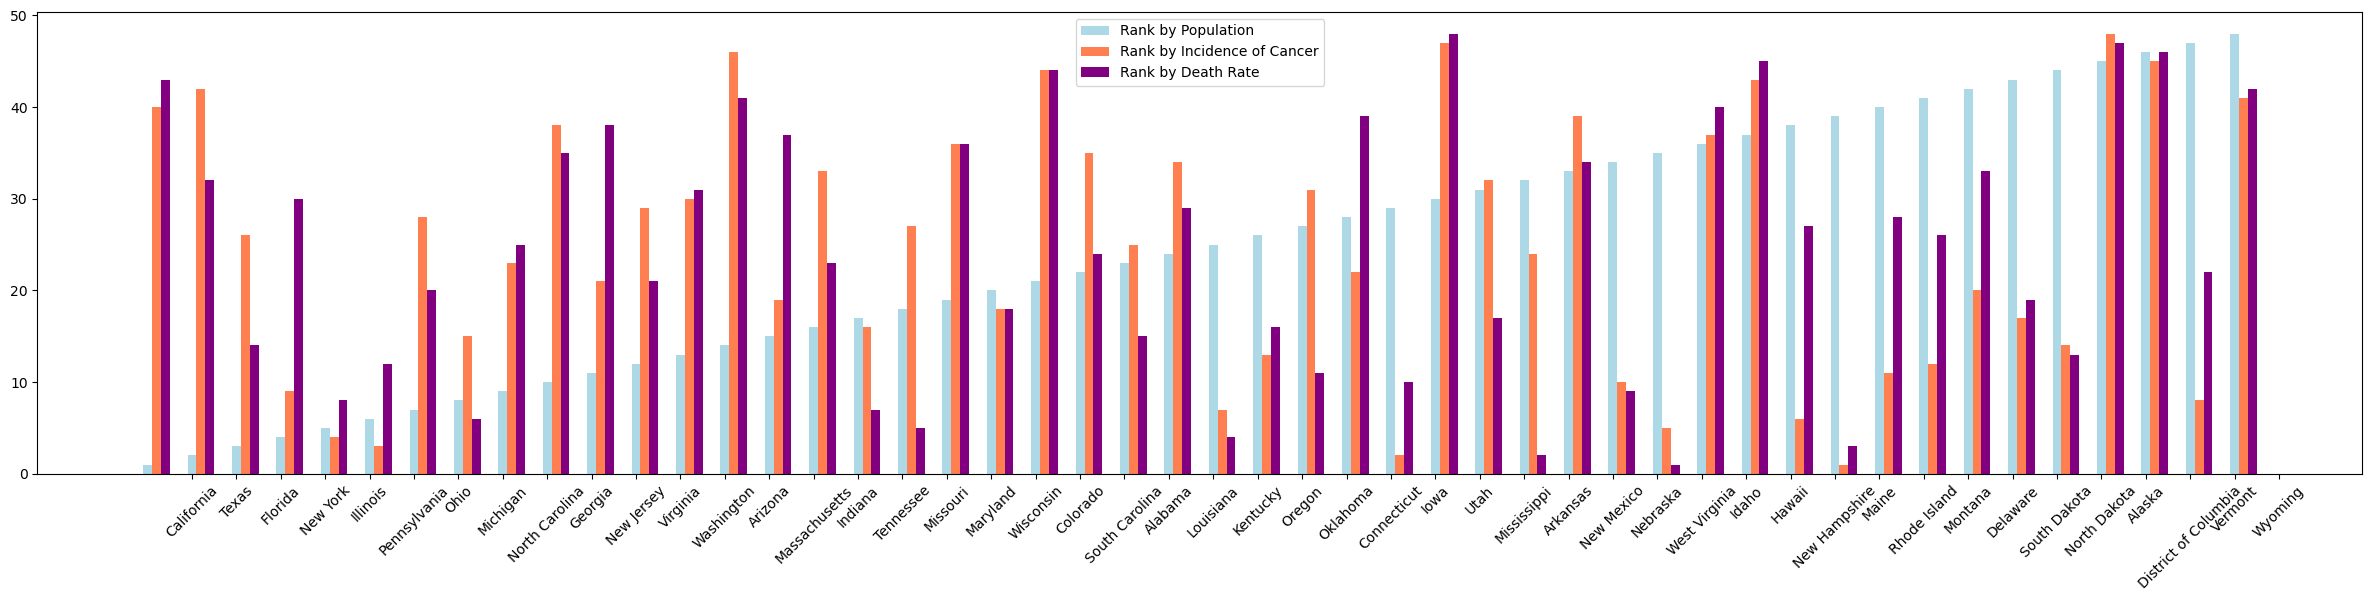

In [27]:
bar1 = np.arange(len(df_state_ranked.index))
bar2 = [x + 0.2 for x in bar1] 
bar3 = [x + 0.2 for x in bar2]

plt.figure(figsize=(30,6))
plt.bar(bar1, df_state_ranked['PopulationRank'], width=0.2, color='lightblue', label = 'Rank by Population')
plt.bar(bar2, df_state_ranked['IncidenceRank'], width=0.2, color='coral', label = 'Rank by Incidence of Cancer')
plt.bar(bar3, df_state_ranked['DeathRank'], width=0.2, color='purple', label = 'Rank by Death Rate')
plt.xticks(ticks=df_state_ranked['PopulationRank'], labels=df_state_ranked.index, rotation=45)
plt.legend() 
plt.show()

In [28]:
df_state_ranked.to_csv("Resources/StateRanks.csv", index=True, header=True)